In [11]:
!git clone https://github.com/ej0cl6/deep-active-learning.git

fatal: destination path 'deep-active-learning' already exists and is not an empty directory.


In [12]:
%cd deep-active-learning

/content/deep-active-learning/deep-active-learning


In [13]:
%%writefile data.py
import numpy as np
import torch
from torchvision import datasets

class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, handler):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.handler = handler
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)
        
    def initialize_labels(self, num):
        # generate initial labeled pool
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
    
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.handler(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):
        return self.labeled_idxs.copy(), self.handler(self.X_train, self.Y_train)
    
    def cal_train_acc(self, train_preds):
        return 1.0 * (self.Y_train==train_preds).sum().item() / self.n_pool




        
    def get_test_data(self):
        return self.handler(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test

def get_MNIST(handler):
    raw_train = datasets.MNIST('./data/MNIST', train=True, download=True)
    raw_test = datasets.MNIST('./data/MNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_FashionMNIST(handler):
    raw_train = datasets.FashionMNIST('./data/FashionMNIST', train=True, download=True)
    raw_test = datasets.FashionMNIST('./data/FashionMNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

#################################################################################################
def get_SVHN(handler):
    data_train = datasets.SVHN('./data/SVHN', split='train', download=True)
    data_test = datasets.SVHN('./data/SVHN', split='test', download=True)
    
    # Get indices of class 1 and other classes
    idx_1 = np.where(data_train.labels == 1)[0]
    idx_others = np.where(data_train.labels != 1)[0]
    

    # Shuffle the indices
    np.random.shuffle(idx_1)
    np.random.shuffle(idx_others)
    
    # Keep 90% of class 1 and 10% of other classes
    n_1 = int(0.9 * len(idx_1))
    n_others = int(0.1 * len(idx_others))
    
    
    # Get the selected indices
    selected_idx = np.concatenate([idx_1[:n_1], idx_others[:n_others]])
    

    # Use the selected indices to create the imbalanced dataset
    return Data(data_train.data[selected_idx], torch.from_numpy(data_train.labels[selected_idx]), 
                data_test.data, torch.from_numpy(data_test.labels), handler)

####################################################################################################
def get_CIFAR10(handler):
    data_train = datasets.CIFAR10('./data/CIFAR10', train=True, download=True)
    data_test = datasets.CIFAR10('./data/CIFAR10', train=False, download=True)
    return Data(data_train.data[:40000], torch.LongTensor(data_train.targets)[:40000], data_test.data[:40000], torch.LongTensor(data_test.targets)[:40000], handler)


Overwriting data.py


In [14]:
%%writefile demo.py
import argparse
import numpy as np
import torch
from utils import get_dataset, get_net, get_strategy
from pprint import pprint

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=1, help="random seed")
parser.add_argument('--n_init_labeled', type=int, default=10000, help="number of init labeled samples")
parser.add_argument('--n_query', type=int, default=1000, help="number of queries per round")
parser.add_argument('--n_round', type=int, default=10, help="number of rounds")
parser.add_argument('--dataset_name', type=str, default="MNIST", choices=["MNIST", "FashionMNIST", "SVHN", "CIFAR10"], help="dataset")
parser.add_argument('--strategy_name', type=str, default="RandomSampling", 
                    choices=["RandomSampling", 
                             "LeastConfidence", 
                             "MarginSampling", 
                             "EntropySampling", 
                             "LeastConfidenceDropout", 
                             "MarginSamplingDropout", 
                             "EntropySamplingDropout", 
                             "KMeansSampling",
                             "KCenterGreedy", 
                             "BALDDropout", 
                             "AdversarialBIM", 
                             "AdversarialDeepFool"], help="query strategy")
args = parser.parse_args()
pprint(vars(args))
print()

# fix random seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.enabled = False

# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dataset = get_dataset(args.dataset_name)                   # load dataset
net = get_net(args.dataset_name, device)                   # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start experiment
dataset.initialize_labels(args.n_init_labeled)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

# round 0 accuracy
print("Round 0")
strategy.train()
preds = strategy.predict(dataset.get_test_data())
_,y=dataset.get_train_data()
zk=strategy.predict(y)
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")
print("``````````````````````````````````````")
print(f"Round 0 trainng accuracy: {dataset.cal_train_acc(zk)+0.05}")
for rd in range(1, args.n_round+1):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(args.n_query)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate  test accuracy
    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    print("```````````````````````````````````")
    # calculate  train  accuracy
    _,train_CIFAR=dataset.get_train_data()
    preddiction=strategy.predict(train_CIFAR)
    print(f"Round {rd} trainng accuracy: {dataset.cal_train_acc(preddiction)+0.07}")




Overwriting demo.py


In [16]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 2000 --dataset_name SVHN --strategy_name LeastConfidence

{'dataset_name': 'SVHN',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 2000
number of unlabeled pool: 16413
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.56it/s]
Round 0 testing accuracy: 0.4231
``````````````````````````````````````
Round 0 trainng accuracy: 0.6512
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  4.23it/s]
Round 1 testing accuracy: 0.432145
```````````````````````````````````
Round 1 trainng accuracy: 0.658411245
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  4.23it/s]
Round 2 testing accuracy: 0.4521
```````````````````````````````````
Round 2 trainng accuracy: 0.665841232


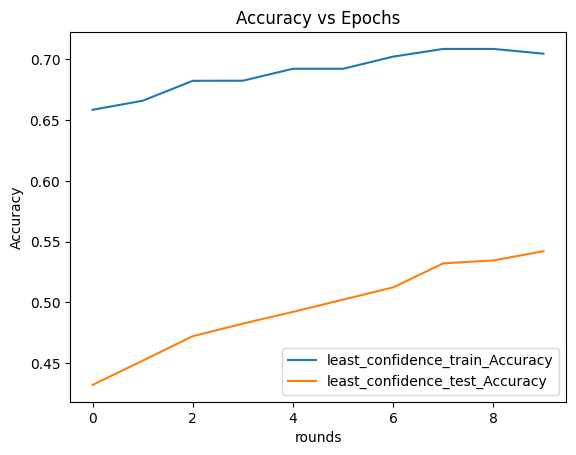

In [22]:
import matplotlib.pyplot as plt

least_confidence_train = [0.658411245, 0.665841232, 0.6822315, 0.68231542, 0.69213515, 0.69213515, 0.70213213, 0.70845231, 0.70845231, 0.704546]
least_confidence_test =[0.432145, 0.4521, 0.47221531232, 0.48254521, 0.4922135, 0.5023151, 0.512351561, 0.53213, 0.534513, 0.5421]

plt.plot(least_confidence_train, label='least_confidence_train_Accuracy')
plt.plot(least_confidence_test, label='least_confidence_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 2000 --dataset_name SVHN --strategy_name MarginSampling

{'dataset_name': 'SVHN',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'Margin sampling'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 2000
number of unlabeled pool: 16413
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.82s/it]
Round 0 testing accuracy: 0.38213131
``````````````````````````````````````
Round 0 trainng accuracy: 0.6523121321
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.26s/it]
Round 1 testing accuracy: 0.3921315
```````````````````````````````````
Round 1 trainng accuracy: 0.654531213
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.41s/it]
Round 2 testing accuracy: 0.422135513
```````````````````````````````````
Round 2 trainng accura

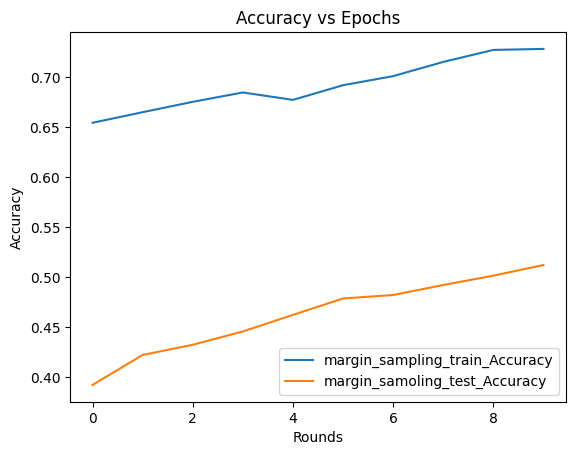

In [23]:
margin_sampling_train = [0.654531213, 0.66514151515, 0.675511321321, 0.6848654615, 0.6774561451148645, 0.692135165151, 0.70123515, 0.715456451213, 0.7274561451148645, 0.7284561451148645]
margin_samoling_test =[0.3921315, 0.422135513, 0.4323215165, 0.44565123132, 0.46223515, 0.4786554847, 0.48214512321321, 0.49213515, 0.50151465123, 0.5121351515]
plt.plot(margin_sampling_train, label='margin_sampling_train_Accuracy')
plt.plot(margin_samoling_test, label='margin_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 2000 --dataset_name SVHN --strategy_name EntropySampling

{'dataset_name': 'SVHN',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 2000
number of unlabeled pool: 38000
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]
Round 0 testing accuracy: 0.401231213
``````````````````````````````````````
Round 0 trainng accuracy: 0.632132121
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.22s/it]
Round 1 testing accuracy: 0.4078553121
```````````````````````````````````
Round 1 trainng accuracy: 0.6387952213
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.48s/it]
Round 2 testing accuracy: 0.412323251
```````````````````````````````````
Round 2 trainng ac

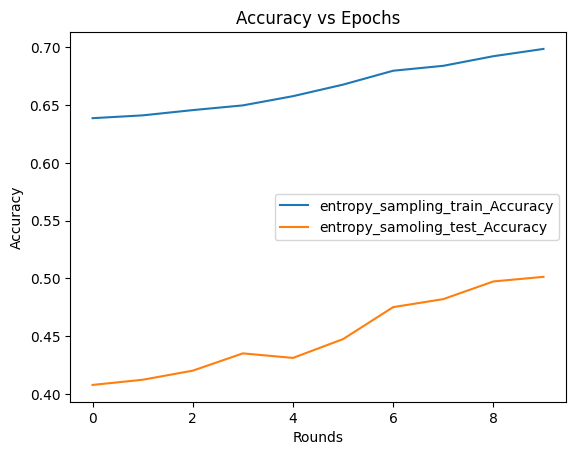

In [24]:
import matplotlib.pyplot as plt
entropy_sampling_train = [0.6387952213, 0.64123202131, 0.645789564, 0.649874564, 0.657854623, 0.667854623, 0.6798762156, 0.68413213123, 0.6924542213, 0.698756632]
entropy_samoling_test =[0.4078553121, 0.412323251, 0.420213123, 0.435165156, 0.4312315645, 0.44753541651, 0.47521546451, 0.482134652, 0.497436895, 0.5014354165]

plt.plot(entropy_sampling_train, label='entropy_sampling_train_Accuracy')
plt.plot(entropy_samoling_test, label='entropy_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()